# Clustering

Clustering techniques are unsupervised learning algorithms that try to group unlabelled data into "clusters", using the (typically spatial) structure of the data itself.

The easiest way to demonstrate how clustering works is to simply generate some data and show them in action. We'll start off by importing the libraries we'll be using today.

In [1]:
%matplotlib inline
import math, numpy as np, matplotlib.pyplot as plt, operator, torch

## Create data

In [2]:
n_clusters=6
n_samples =250

To generate our data, we're going to pick 6 random points, which we'll call centroids, and for each point we're going to generate 250 random points about it.

In [3]:
centroids = np.random.uniform(-35, 35, (n_clusters, 2))
slices = [np.random.multivariate_normal(centroids[i], np.diag([5., 5.]), n_samples)
           for i in range(n_clusters)]
data = np.concatenate(slices).astype(np.float32)

Below we can see each centroid marked w/ X, and the coloring associated to each respective cluster.

In [4]:
def plot_data(centroids, data, n_samples):
    colour = plt.cm.rainbow(np.linspace(0,1,len(centroids)))
    for i, centroid in enumerate(centroids):
        samples = data[i*n_samples:(i+1)*n_samples]
        plt.scatter(samples[:,0], samples[:,1], c=colour[i], s=1)
        plt.plot(centroid[0], centroid[1], markersize=10, marker="x", color='k', mew=5)
        plt.plot(centroid[0], centroid[1], markersize=5, marker="x", color='m', mew=2)

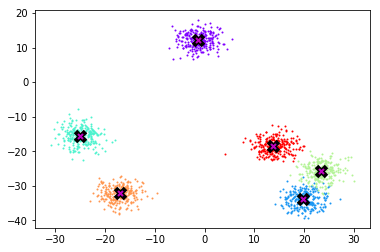

In [5]:
plot_data(centroids, data, n_samples)

## Mean shift

Most people that have come across clustering algorithms have learnt about **k-means**. Mean shift clustering is a newer and less well-known approach, but it has some important advantages:
* It doesn't require selecting the number of clusters in advance, but instead just requires a **bandwidth** to be specified, which can be easily chosen automatically
* It can handle clusters of any shape, whereas k-means (without using special extensions) requires that clusters be roughly ball shaped.

The algorithm is as follows:
* For each data point x in the sample X, find the distance between that point x and every other point in X
* Create weights for each point in X by using the **Gaussian kernel** of that point's distance to x
    * This weighting approach penalizes points further away from x
    * The rate at which the weights fall to zero is determined by the **bandwidth**, which is the standard deviation of the Gaussian
![Gaussian](http://images.books24x7.com/bookimages/id_5642/fig11-10.jpg)
* Update x as the weighted average of all other points in X, weighted based on the previous step

This will iteratively push points that are close together even closer until they are next to each other.

So here's the definition of the gaussian kernel, which you may remember from high school...

In [6]:
def gaussian(d, bw):
    return np.exp(-0.5*((d/bw))**2) / (bw*math.sqrt(2*math.pi))

 This person at the science march certainly remembered!

<img src="http://i.imgur.com/nijQLHw.jpg" width=400>

In our implementation, we choose the bandwidth to be 2.5. 

One easy way to choose bandwidth is to find which bandwidth covers one third of the data.

In [7]:
def meanshift(data):
    X = np.copy(data)
    for it in range(5):
        for i, x in enumerate(X):
            dist = np.sqrt(((x-X)**2).sum(1))
            weight = gaussian(dist, 2.5)
            X[i] = (np.expand_dims(weight,1)*X).sum(0) / weight.sum()
    return X

In [8]:
%time X=meanshift(data)

CPU times: user 876 ms, sys: 0 ns, total: 876 ms
Wall time: 875 ms


We can see that mean shift clustering has almost reproduced our original clustering. The one exception are the very close clusters, but if we really wanted to differentiate them we could lower the bandwidth.

What is impressive is that this algorithm nearly reproduced the original clusters without telling it how many clusters there should be.

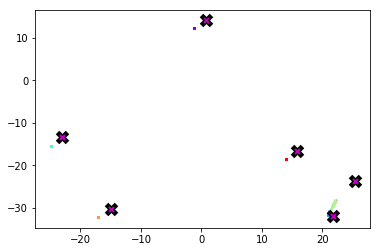

In [9]:
plot_data(centroids+2, X, n_samples)

We should be able to accelerate this algorithm with a GPU.

## Broadcasting

In [10]:
v=np.array([1,2,3]); v, v.shape

(array([1, 2, 3]), (3,))

In [11]:
m=np.array([v,v*2,v*3]); m, m.shape

(array([[1, 2, 3],
        [2, 4, 6],
        [3, 6, 9]]), (3, 3))

In [12]:
m+v

array([[ 2,  4,  6],
       [ 3,  6,  9],
       [ 4,  8, 12]])

In [13]:
v1=np.expand_dims(v,-1); v1, v1.shape

(array([[1],
        [2],
        [3]]), (3, 1))

In [14]:
m+v1

array([[ 2,  3,  4],
       [ 4,  6,  8],
       [ 6,  9, 12]])

Pytorch does not support broadcasting, therefore I have replaced the operators with broadcasting versions.

In [15]:
def unit_prefix(x, n=1):
    for i in range(n): x = x.unsqueeze(0)
    return x

def align(x, y, start_dim=2):
    xd, yd = x.dim(), y.dim()
    if xd > yd: y = unit_prefix(y, xd - yd)
    elif yd > xd: x = unit_prefix(x, yd - xd)

    xs, ys = list(x.size()), list(y.size())
    nd = len(ys)
    for i in range(start_dim, nd):
        td = nd-i-1
        if   ys[td]==1: ys[td] = xs[td]
        elif xs[td]==1: xs[td] = ys[td]
    return x.expand(*xs), y.expand(*ys)

def aligned_op(x,y,f): return f(*align(x,y,0))

def add(x, y): return aligned_op(x, y, operator.add)
def sub(x, y): return aligned_op(x, y, operator.sub)
def mul(x, y): return aligned_op(x, y, operator.mul)
def div(x, y): return aligned_op(x, y, operator.truediv)

## GPU-accelerated mean shift in pytorch

One advantage of pytorch is that it's very similar to numpy. For instance, the definition of `gaussian` is identical, except for the namespace.

In [16]:
def gaussian(d, bw):
    return torch.exp(-0.5*((d/bw))**2) / (bw*math.sqrt(2*math.pi))

And the implementation of meanshift is nearly identical too!

In [17]:
def meanshift(data):
    X = torch.FloatTensor(np.copy(data))
    for it in range(5):
        for i, x in enumerate(X):
            dist = torch.sqrt((sub(x, X)**2).sum(1))
            weight = gaussian(dist, 3).unsqueeze(1)  # - Adapted to obtain working shape
            num = mul(weight, X).sum(0).unsqueeze(0)  # - Adapted to obtain working shape
            X[i] = num / weight.sum()
    return X

This implementation actually takes longer. Oh dear! What do you think is causing this?

In [18]:
%time X = meanshift(data).numpy()

CPU times: user 1.11 s, sys: 4 ms, total: 1.12 s
Wall time: 1.11 s


All the computation is happening in the <tt>for</tt> loop, which isn't accelerated by pytorch. Each iteration launches a new cuda kernel, which takes time and slows the algorithm down as a whole. Furthermore, each iteration doesn't have enough processing to do to fill up all of the threads of the GPU. But at least the results are correct...

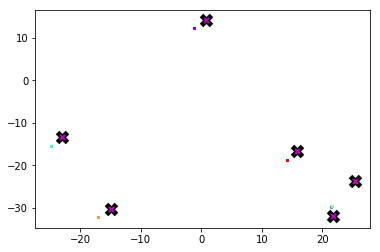

In [19]:
plot_data(centroids+2, X, n_samples)

## GPU batched algorithm

To truly accelerate the algorithm, we need to be performing updates on a batch of points per iteration, instead of just one as we were doing.

In [20]:
def dist_b(a,b):
    return torch.sqrt((sub(a.unsqueeze(0),b.unsqueeze(1))**2).sum(2))

In [21]:
a=torch.rand(2,2)
b=torch.rand(3,2)
# dist_b(b, a).squeeze(2)  # - changed to obtain working shape
dist_b(b, a)


 0.7002  0.4179  0.5426
 0.5863  0.3705  0.4278
[torch.FloatTensor of size 2x3]

In [22]:
def gaussian(d, bw):
    return torch.exp(-0.5*((d/bw))**2) / (bw*math.sqrt(2*math.pi))

In [23]:
def sum_sqz(a,axis): return a.sum(axis).squeeze(axis)

In [24]:
def meanshift(data, bs=500):
    n = len(data)
    X = torch.FloatTensor(np.copy(data)).cuda()
    for it in range(5):
        for i in range(0,n,bs):
            s = slice(i,min(n,i+bs))
            weight = gaussian(dist_b(X, X[s]), 2).unsqueeze(2)  # - Adapted to obtain working shape
            num = sum_sqz(mul(weight, X), 1)
            X[s] = div(num, sum_sqz(weight, 1).unsqueeze(1))  # - Adapted to obtain working shape
    return X

Although each iteration still has to launch a new cuda kernel, there are now fewer iterations, and the acceleration from updating a batch of points more than makes up for it.

In [25]:
%time X = meanshift(data).cpu().numpy()

CPU times: user 1.3 s, sys: 604 ms, total: 1.9 s
Wall time: 1.89 s


That's more like it! We've gone from 914ms to 44ms, which is a speedup of over 2000%. Oh, and it even gives the right answer:

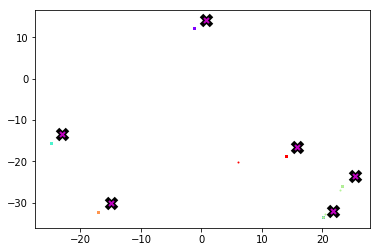

In [26]:
plot_data(centroids+2, X, n_samples)

## course.fast.ai

If you found this interesting, you might enjoy the 30+ hours of deep learning lessons at [course.fast.ai](course.fast.ai). There's also a very active forum of deep learning practitioners and learners at [forums.fast.ai](forums.fast.ai). Hope to see you there! :)